# Fitting the telluric line model

*January 7th 2024, Hajime Kawahara*

Let's try modeling the telluric lines, which is one of the nuisances in high-resolution spectral observations by ground-based telescopes, using `ExoJAX` in this notebook.
We use the external packages, `specutils` and `JoviSpec` in this notebook. 

To install specutils and JoviSpec, run the following commands

```sh
pip install specutils
git clone https://github.com/HajimeKawahara/jovispec.git
cd jovispec
python setup.py install
``````

In [1]:
from jax.config import config

config.update("jax_enable_x64", True)

First, as our data, we will use the spectrum of an A-type star called WASP-33, which was captured with Subaru/HDS. In fact, on the same night, we also obtained the spectrum of Jupiter, and the repository primarily for publishing Jupiter's reflected light data is JoviSpec.

Let me share a little memory about this data. This data was my first attempt at molecular detection in exoplanets using the `Subaru Telescope`. In 2012, a paper by M. Brogi et al. on CO detection using VLT/CRIRES, [Brogi et al. 2012, Nature 486, 7404](https://arxiv.org/abs/1206.6109), was published. VLT/CRIRES, being a high-resolution spectrometer in the near-infrared, was ideal for detecting the thermal radiation from hot Jupiters. In Japan, at that time, the only high-resolution spectrometer (with R close to 100,000) attached to the Subaru Telescope was HDS (of course, now there is IRD!), so I thought of observing the super-hot Jupiter WASP33b, whose blackbody radiation extends to the visible region, and detecting TiO. But this was my first proposal to `Subaru Telescope`, and it was rejected the first time. It passed on the second try, and my first trip to the summit of Mauna Kea was for this observation.

The observation in the fall of 2014 was my first experience with the 'Subaru Telescope'. Due to bad weather until the day before, the humidity was high, and we struggled to open the telescope. Finally, when the humidity dropped, we were able to capture the data of WASP33. However, morning came quickly. So, we persisted until the last moment to capture Jupiter, and that data is the high-resolution Jupiter reflected light data provided by [JoviSpec](https://github.com/HajimeKawahara/jovispec).

By the way, in the following year, despite my recollection of a hurricane being present, we were fortunate with the weather during the observation nights and were able to collect data with good signal-to-noise ratio (S/N). With the data from 2015, we were able to report on `TiO` and the temperature inversion layer in [Nugroho et al. (2017) AJ 154, 221](https://arxiv.org/abs/1710.05276).

Sorry for the long story, but this star, WASP33, being an A-type star with a large vsini, means that most of the high-frequency components in its spectrum are actually telluric lines. Therefore, we will use the spectrum of this WASP33 as an example for a simple model of telluric lines.

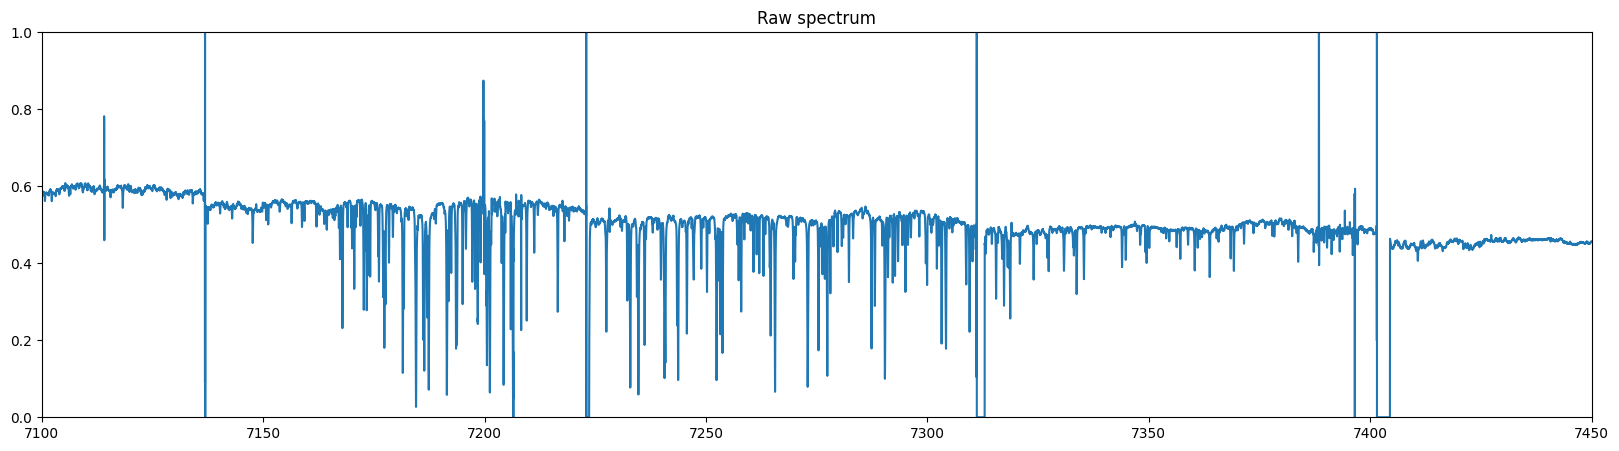

In [2]:
from jovispec import abcio
import pkg_resources

jupiter_data = pkg_resources.resource_filename("jovispec", "jupiter_data")

# blue
rlamb2, rspec2, rhead = abcio.read_qfits("06002", jupiter_data, ext="q")  # WASP33b
rlamb3, rspec3, rhead = abcio.read_qfits("06004", jupiter_data, ext="q")  # WASP33b
rlamb4, rspec4, rhead = abcio.read_qfits("06006", jupiter_data, ext="q")  # WASP33b
rlamb5, rspec5, rhead = abcio.read_qfits("06008", jupiter_data, ext="q")  # WASP33b
rlamb = rlamb2
rspec = rspec2 + rspec3 + rspec4 + rspec5

wavelength_start = 7100.0  # AA
wavelength_end = 7450.0  # AA

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 5))
plt.plot(rlamb, rspec)
plt.ylim(0.0, 1.0)
plt.xlim(wavelength_start, wavelength_end)
plt.title("Raw spectrum")
plt.show()

First, we'll start with some basic cleaning of the data. As those familiar with ground-based high-resolution spectra know, high-resolution spectra often have outliers near the edges of orders and in other places. We'll mask these outliers. For the analysis, let's limit ourselves to the wavelength region where water's telluric lines are visible. Interestingly, Jupiter's strong methane feature is in the same region, so in the notebook for reflected light analysis, we'll analyze the same region using Jupiter's spectrum this time.

Next, we'll convert the wavelengths from air values to vacuum values. We should also define the wavenumber grid.

In ExoJAX, don't forget to set the wavenumber grid in ascending order. As a result, make sure that when viewed in the wavelength grid, it appears in descending order.

In [3]:
import numpy as np

# mask some bad regions... as usual in astronomy  
mask_wav = [
[7114.0,7114.2],
[7136.8, 7137.0],
[7199.0,7200.0],
[7205.8,7206.0],
[7206.25,7206.75],
[7208.2,7208.4],
[7222.8,7224.0],
[7311.0,7313.],
[7388.3,7388.5],
[7396.4,7396.6],
[7401.0,7405.0]
]
rlamb = np.array([float(d) for d in rlamb])
mask_index=np.digitize(mask_wav,rlamb)
for ind in mask_index:
    rspec[ind[0]:ind[1]+1] = None


# None for outside wvelength start - end region
start_index=np.digitize(wavelength_start,rlamb)
end_index=np.digitize(wavelength_end,rlamb)
rspec[:start_index] = None
rspec[end_index:] = None

#Air-Vaccum correction
from specutils.utils.wcs_utils import refraction_index
import astropy.units as u
mask = rspec == rspec
rlamb = rlamb[mask]
rspec = rspec[mask]
nair = refraction_index(rlamb*u.AA,method="Ciddor1996")
rlamb = rlamb*nair

# ascending wavenumber form
from exojax.spec.unitconvert import wav2nu
rlamb = rlamb[::-1]
nus_obs = wav2nu(rlamb, unit="AA")
rspec = rspec[::-1]


It's common for spectra to have a trend, and while it would be proper to model it seriously using methods like Gaussian processes, let's take a shortcut here and see how well we can do with a median filter.

In [4]:

#median filter
from scipy.signal import medfilt
mspec = medfilt(rspec, kernel_size=1001)

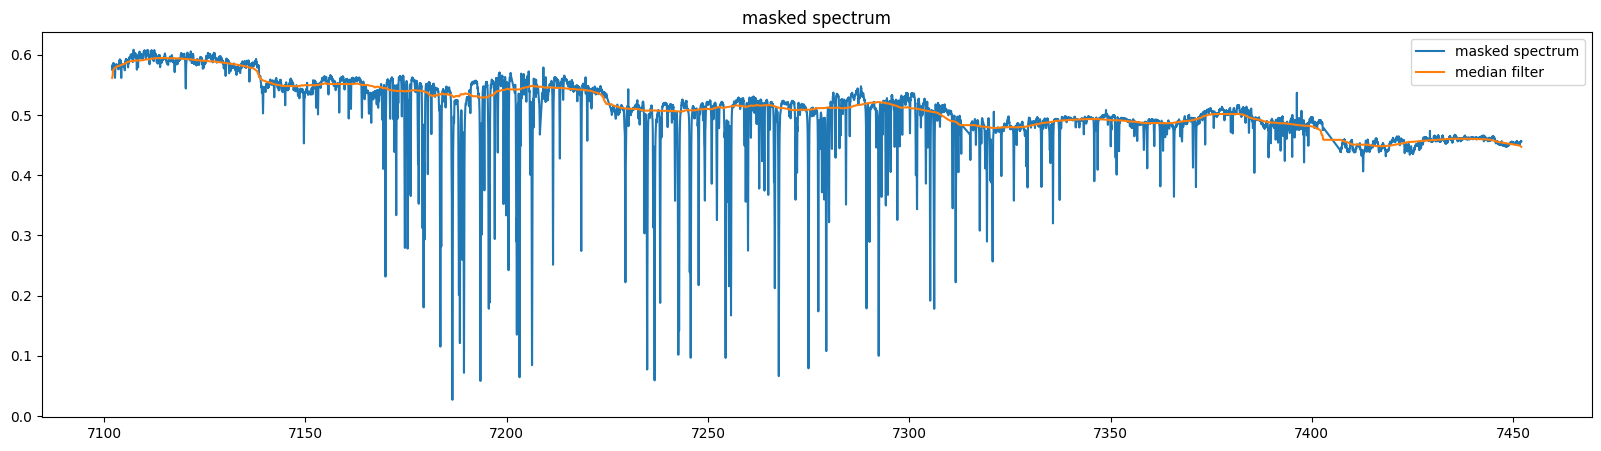

In [5]:
fig = plt.figure(figsize=(20,5))
plt.plot(rlamb,rspec, label="masked spectrum")
plt.plot(rlamb,mspec, label="median filter")
plt.legend()
plt.title("masked spectrum")
plt.show()

Since the results are reasonably good, let's go ahead and divide the spectrum by the median filter. But remember, this is a lazy approach!

In [6]:
#median subtracted
rspec = rspec/mspec*np.mean(rspec)

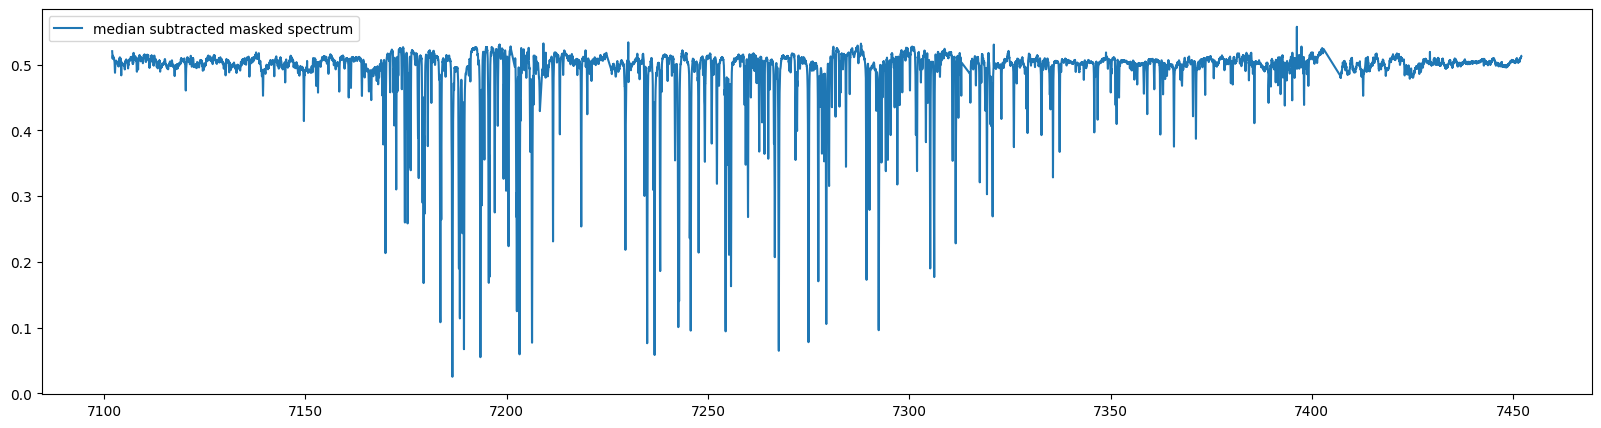

In [7]:
fig = plt.figure(figsize=(20,5))
plt.plot(rlamb,rspec, label="median subtracted masked spectrum")
plt.legend()
plt.show()

Now we get to the main part. Since it's a low-temperature environment, HITRAN is sufficient as the molecular database (originally, HITRAN was developed for Earth's atmosphere). For the opacity calculator, although `Direct` could be used, here we'll use `PreMODIT`.

In [8]:
wavelength_start = 7100.0  # AA
wavelength_end = 7450.0  # AA
from exojax.spec.api import MdbHitran
from exojax.spec.opacalc import OpaDirect
from exojax.spec.opacalc import OpaPremodit
from exojax.utils.grids import wavenumber_grid
from exojax.spec.unitconvert import wav2nu

N = 40000

margin = 10  # cm-1
nus_start = wav2nu(wavelength_end, unit="AA") - margin
nus_end = wav2nu(wavelength_start, unit="AA") + margin
#nus_start = 1.e8/wavelength_end - margin
#nus_end = 1.e8/wavelength_start + margin

mdb_water = MdbHitran("H2O", nurange=[nus_start, nus_end], isotope=1)
nus, wav, res = wavenumber_grid(nus_start, nus_end, N, xsmode="lpf", unit="cm-1")
# opa = OpaDirect(mdb_water, nu_grid=nus)
opa = OpaPremodit(mdb_water, nu_grid=nus, allow_32bit=True, auto_trange=[150.0, 300.0])

xsmode =  lpf
xsmode assumes ESLOG in wavenumber space: mode=lpf
We changed the policy of the order of wavenumber/wavelength grids
wavenumber grid should be in ascending order and now 
users can specify the order of the wavelength grid by themselves.
Your wavelength grid is in ***  descending  *** order
This might causes the bug if you update ExoJAX. 
Note that the older ExoJAX assumes ascending order as wavelength grid.
OpaPremodit: params automatically set.
Robust range: 148.362692491353 - 337.48243799560873 K
Change the reference temperature from 296.0K to 163.08464046497667 K.
OpaPremodit: Tref_broadening is set to  212.1320343559642 K
OpaPremodit: gamma_air and n_air are used. gamma_ref = gamma_air/Patm
# of reference width grid :  18
# of temperature exponent grid : 4


/home/kawahara/exojax/src/exojax/spec/set_ditgrid.py:52: UserWarning: There exists negative or zero value.
  warnings.warn("There exists negative or zero value.")
uniqidx: 100%|████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 3263.52it/s]


Premodit: Twt= 282.92333337743037 K Tref= 163.08464046497667 K
Making LSD:|####################| 100%


The most straightforward telluric line model involves an absorber with a single temperature, pressure, and column density. It's worth noting that `@YuiKasagi` was the first to try this model in ExoJAX.

It seems to fit the data reasonably well (as initial values) with appropriate values.

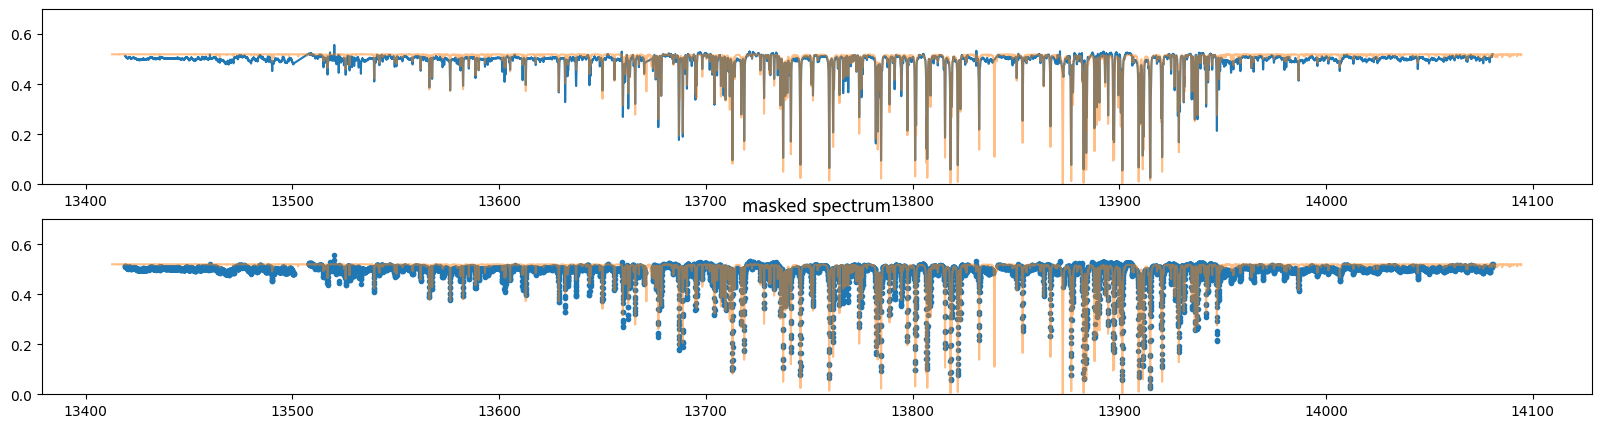

In [9]:
import jax.numpy as jnp

T = 200.0
P = 0.5
xsv = opa.xsvector(T, P)
nl = 2.0e22
a = 0.52

fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(211)
plt.plot(nus_obs, rspec)
plt.ylim(0.0, 0.7)
plt.plot(nus, a * jnp.exp(-nl * xsv), alpha=0.5)
# plt.xlim(1.e8/wavelength_start, 1.e8/wavelength_end)

ax = fig.add_subplot(212)
plt.plot(nus_obs, rspec, ".")
plt.plot(nus, 0.52 * jnp.exp(-nl * xsv), alpha=0.5)
plt.ylim(0.0, 0.7)

# plt.xlim(1.e8/7200,1.e8/7250)

plt.title("masked spectrum")
plt.show()

Now, let's try fitting it using ADAM with these initial values.
Ah, let's remember that the instrumental profile is Gaussian, and we should also consider its width as a fitting parameter.

In [10]:
from exojax.utils.instfunc import resolution_to_gaussian_std

T_b = 200.0
P_b = 0.5
nl_b = 2.0e22
a_b = 0.52
Rinst = 100000.0
beta_inst_b = resolution_to_gaussian_std(Rinst)

initial_guess = np.array([T_b, P_b, nl_b, a_b, beta_inst_b])
initpar = np.ones_like(initial_guess)

In [11]:
# instrumental setting
from exojax.spec.specop import SopInstProfile

sop_inst = SopInstProfile(nus, res)


def model(params):
    T, P, nl, a, beta = params * initial_guess
    xsv = opa.xsvector(T, P)
    trans = a * jnp.exp(-nl * xsv)
    Frot_inst = sop_inst.ipgauss(trans, beta)
    mu = sop_inst.sampling(Frot_inst, 0.0, nus_obs)
    return mu

Let's input the initial values into the defined model and, just to be sure, plot it for a visual check. Looks good.

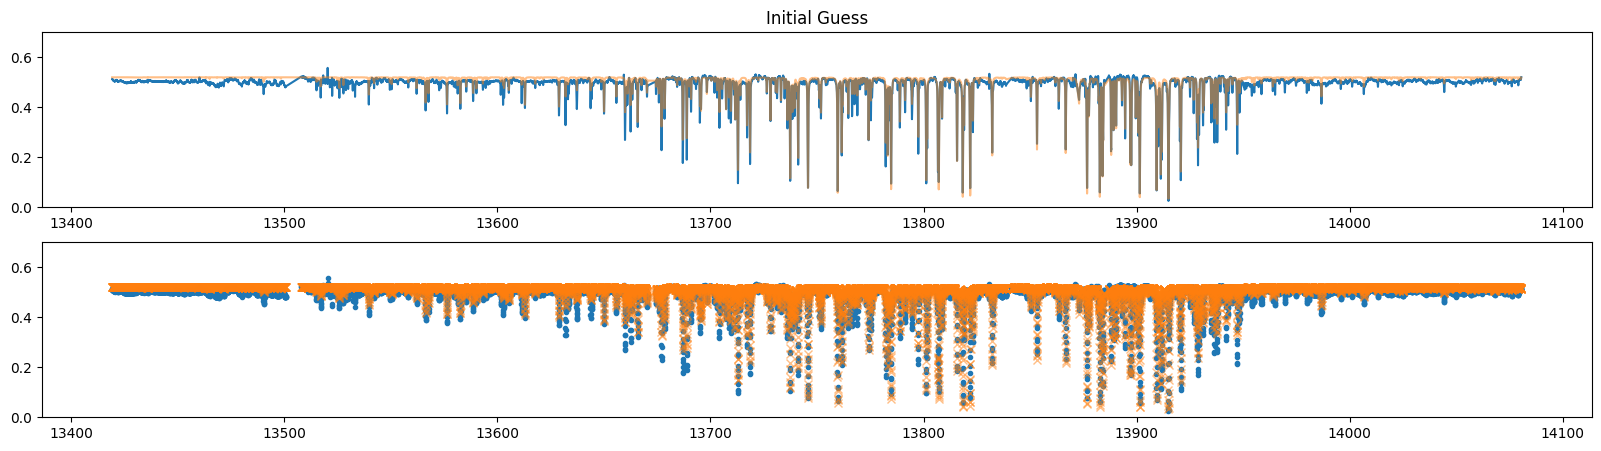

In [12]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(211)
plt.title("Initial Guess")
plt.plot(nus_obs,rspec)
plt.ylim(0.0,0.7)
plt.plot(nus_obs,model(np.ones(5)),alpha=0.5)
#plt.xlim(1.e8/wavelength_start, 1.e8/wavelength_end)

ax = fig.add_subplot(212)
plt.plot(nus_obs,rspec,".")
plt.plot(nus_obs,model(np.ones(5)),"x",alpha=0.5)
plt.ylim(0.0,0.7)

#plt.xlim(1.e8/7200,1.e8/7250)

plt.show()


Defines the objective function... 

In [13]:
def objective(params):
    f=rspec-model(params)
    return jnp.dot(f,f)*1.e-6

Let's do ADAM!

In [14]:
import jaxopt
from jaxopt import OptaxSolver
import optax


#gd = jaxopt.GradientDescent(fun=objective, maxiter=1000, stepsize=1.0)
#res = gd.run(init_params=initpar)
#params, state = res

import tqdm
adam = OptaxSolver(opt=optax.adam(1.e-3), fun=objective)
state = adam.init_state(initpar)
params_a=np.copy(initpar)

params_adam=[]
Nit=300
for _ in  tqdm.tqdm(range(Nit)):
    params_a,state=adam.update(params_a,state)
    params_adam.append(params_a)

params = params_adam[-1]
print(params*initial_guess)

100%|█████████████████████████████████████████████████████████████████████████████████| 300/300 [00:11<00:00, 26.28it/s]

[2.40380537e+02 4.17598205e-01 2.22089558e+22 5.07222559e-01
 1.29431648e+00]


The results seem good! 

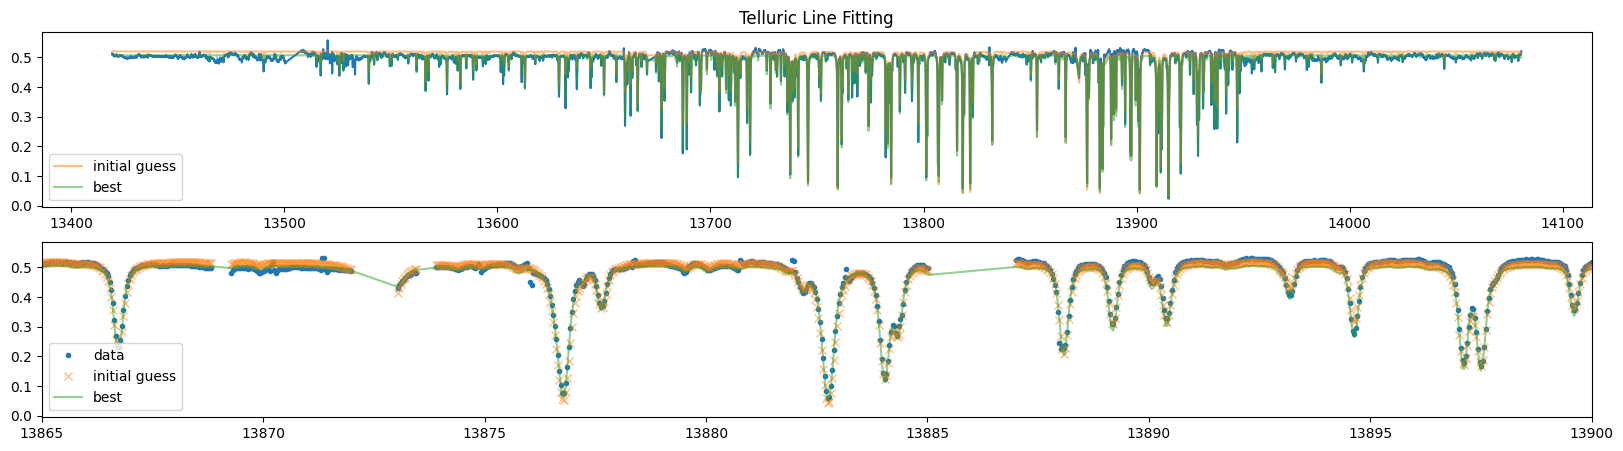

In [15]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(211)
plt.title("Telluric Line Fitting")
plt.plot(nus_obs,rspec)
plt.plot(nus_obs,model(np.ones(len(params))),alpha=0.5, label="initial guess")
plt.plot(nus_obs,model(params),alpha=0.5, label="best")
plt.legend()
ax = fig.add_subplot(212)
plt.plot(nus_obs,rspec,".", label="data")
plt.plot(nus_obs,model(np.ones(len(params))),"x",alpha=0.5, label="initial guess")
plt.plot(nus_obs,model(params),alpha=0.5, label="best")
plt.legend()

#plt.xlim(1.e8/7250,1.e8/7200)
plt.xlim(13865,13900)
#plt.xlim(13865,13870)

plt.show()


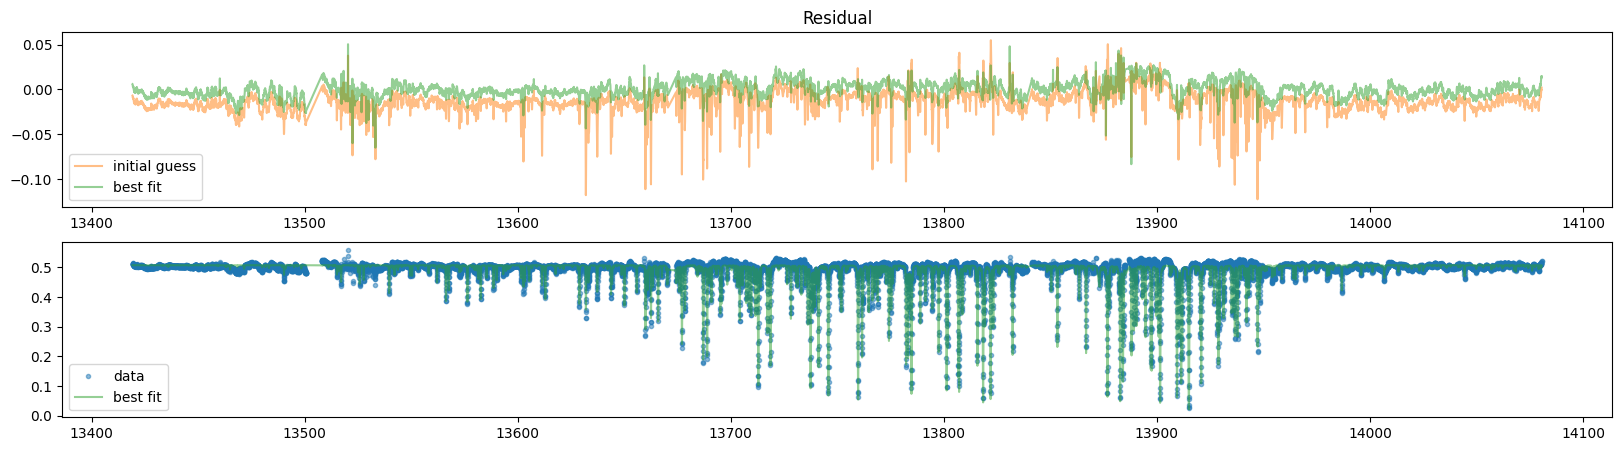

In [16]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(211)
plt.plot(nus_obs,rspec- model(np.ones(len(params))),alpha=0.5,color="C1", label="initial guess")
plt.plot(nus_obs,rspec - model(params),alpha=0.5,color="C2", label="best fit")
plt.title("Residual")
plt.legend()
ax = fig.add_subplot(212)
plt.plot(nus_obs,rspec,".",alpha=0.5,color="C0", label="data")
plt.plot(nus_obs,model(params),alpha=0.5,color="C2", label="best fit")
plt.legend()

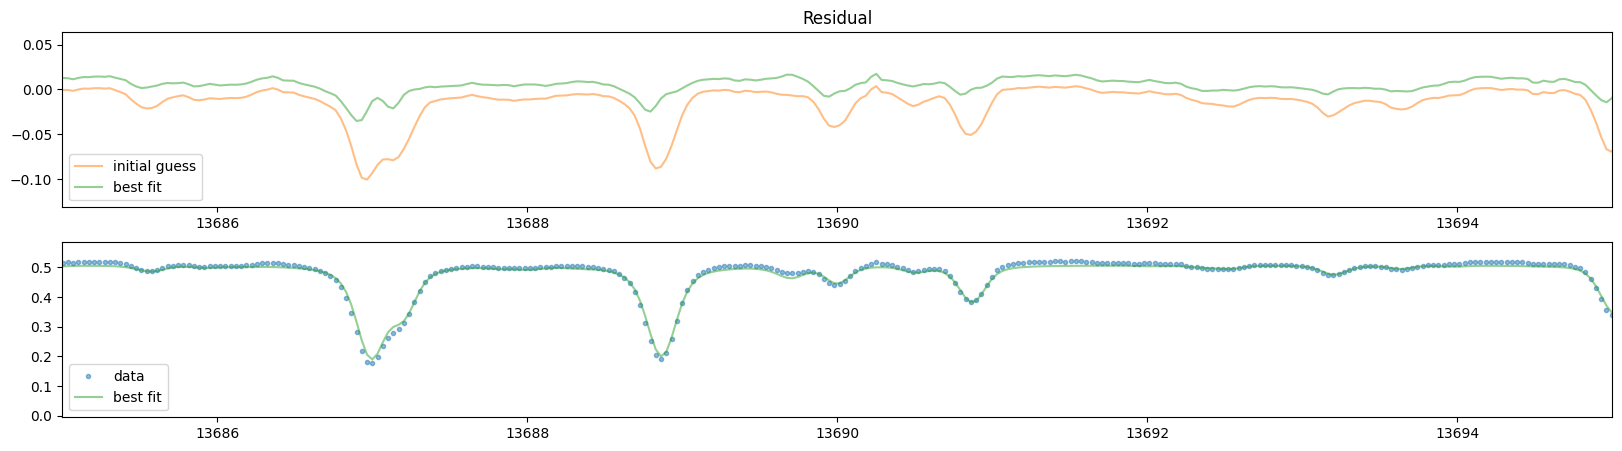

In [17]:
xs=13685
xe=13695
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(211)
plt.title("Residual")
plt.plot(nus_obs,rspec- model(np.ones(len(params))),alpha=0.5,color="C1", label="initial guess")
plt.plot(nus_obs,rspec - model(params),alpha=0.5,color="C2", label="best fit")
plt.xlim(xs,xe)
plt.legend()
ax = fig.add_subplot(212)
plt.plot(nus_obs,rspec,".",alpha=0.5,color="C0", label="data")
plt.plot(nus_obs,model(params),alpha=0.5,color="C2", label="best fit")
plt.xlim(xs,xe)
plt.legend()

So, it looks like even such a simple model can fit the data reasonably well.